In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch

from torch.utils.data import DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.functional import F

from data_process.misclassified_data import *
from data_process.getdata import *

from model import *
from model.model import *
from model.ghostnet_model import *
from model.model_test import *
from model.model_train import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.chdir('d:\Python Projects\EVA')
cwd = os.getcwd()

In [2]:
model_dir = os.path.join(cwd, 'Assignment-6/saved_models')
img_dir = os.path.join(cwd, 'Assignment-6/saved_images')
print(model_dir, img_dir)

d:\Python Projects\EVA\Assignment-6/saved_models d:\Python Projects\EVA\Assignment-6/saved_images


In [3]:
train = GetTrainData.download_train_data(cwd)
test = GetTrainData.download_test_data(cwd)

In [4]:
#
SEED = 1
device = 'cuda' if torch.cuda else 'cpu'

# for Reproducable results
torch.manual_seed(SEED)

#Setting seed if CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# The Model

In [5]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,456
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 10, 10, 10]           1,450
             ReLU-11           [-1, 10, 10, 10]               0
      BatchNorm2d-12           [-1, 10, 10, 10]              20
          Dropout-13           [-1, 10, 10, 10]               0
           Conv2d-14             [-1, 1

# GhostModel

In [6]:
model_ghost = GhostNet().to(device)

In [7]:
# Assignment 6

def get_optim(mode):

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.06)

    if mode is 'l2_bn':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0, dampening=0, weight_decay=0.00001, nesterov=False)
        model_training(model, device, train_dataloader, optimizer, train_acc, train_losses)
        scheduler.step()
    
    elif mode is 'l1_bn':
        model_training(model, device, train_dataloader, optimizer, train_acc, train_losses, l1_loss=True)
        scheduler.step()

    elif mode is 'l1_l2_bn':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0, dampening=0, weight_decay=0.00001, nesterov=False)
        model_training(model, device, train_dataloader, optimizer, train_acc, train_losses, l1_loss=True)
        scheduler.step()

    elif mode is 'gbn':
        model_training(model, device, train_dataloader, optimizer, train_acc, train_losses)
        scheduler.step()

    elif mode is 'l1_l2_gbn':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0, dampening=0, weight_decay=0.00001, nesterov=False)
        model_training(model, device, train_dataloader, optimizer, train_acc, train_losses, l1_loss=True)
        scheduler.step()

0%|          | 0/235 [00:00<?, ?it/s]Mode is gbn
EPOCH -  0
Loss=0.16092218458652496 Batch_id=234 Accuracy=83.12: 100%|██████████| 235/235 [00:13<00:00, 17.53it/s]
  0%|          | 0/235 [00:00<?, ?it/s]
Test set: Average loss: 0.1054, Accuracy: 9779/10000 (97.79%)

EPOCH -  1
Loss=0.061059754341840744 Batch_id=234 Accuracy=97.10: 100%|██████████| 235/235 [00:12<00:00, 19.47it/s]
  0%|          | 0/235 [00:00<?, ?it/s]
Test set: Average loss: 0.0564, Accuracy: 9871/10000 (98.71%)

EPOCH -  2
Loss=0.07959552854299545 Batch_id=234 Accuracy=97.77: 100%|██████████| 235/235 [00:10<00:00, 21.84it/s]
  0%|          | 0/235 [00:00<?, ?it/s]
Test set: Average loss: 0.0458, Accuracy: 9881/10000 (98.81%)

EPOCH -  3
Loss=0.128154456615448 Batch_id=234 Accuracy=98.08: 100%|██████████| 235/235 [00:10<00:00, 22.09it/s]
  0%|          | 0/235 [00:00<?, ?it/s]
Test set: Average loss: 0.0368, Accuracy: 9900/10000 (99.00%)

EPOCH -  4
Loss=0.1194017231464386 Batch_id=234 Accuracy=98.36: 100%|██████████|

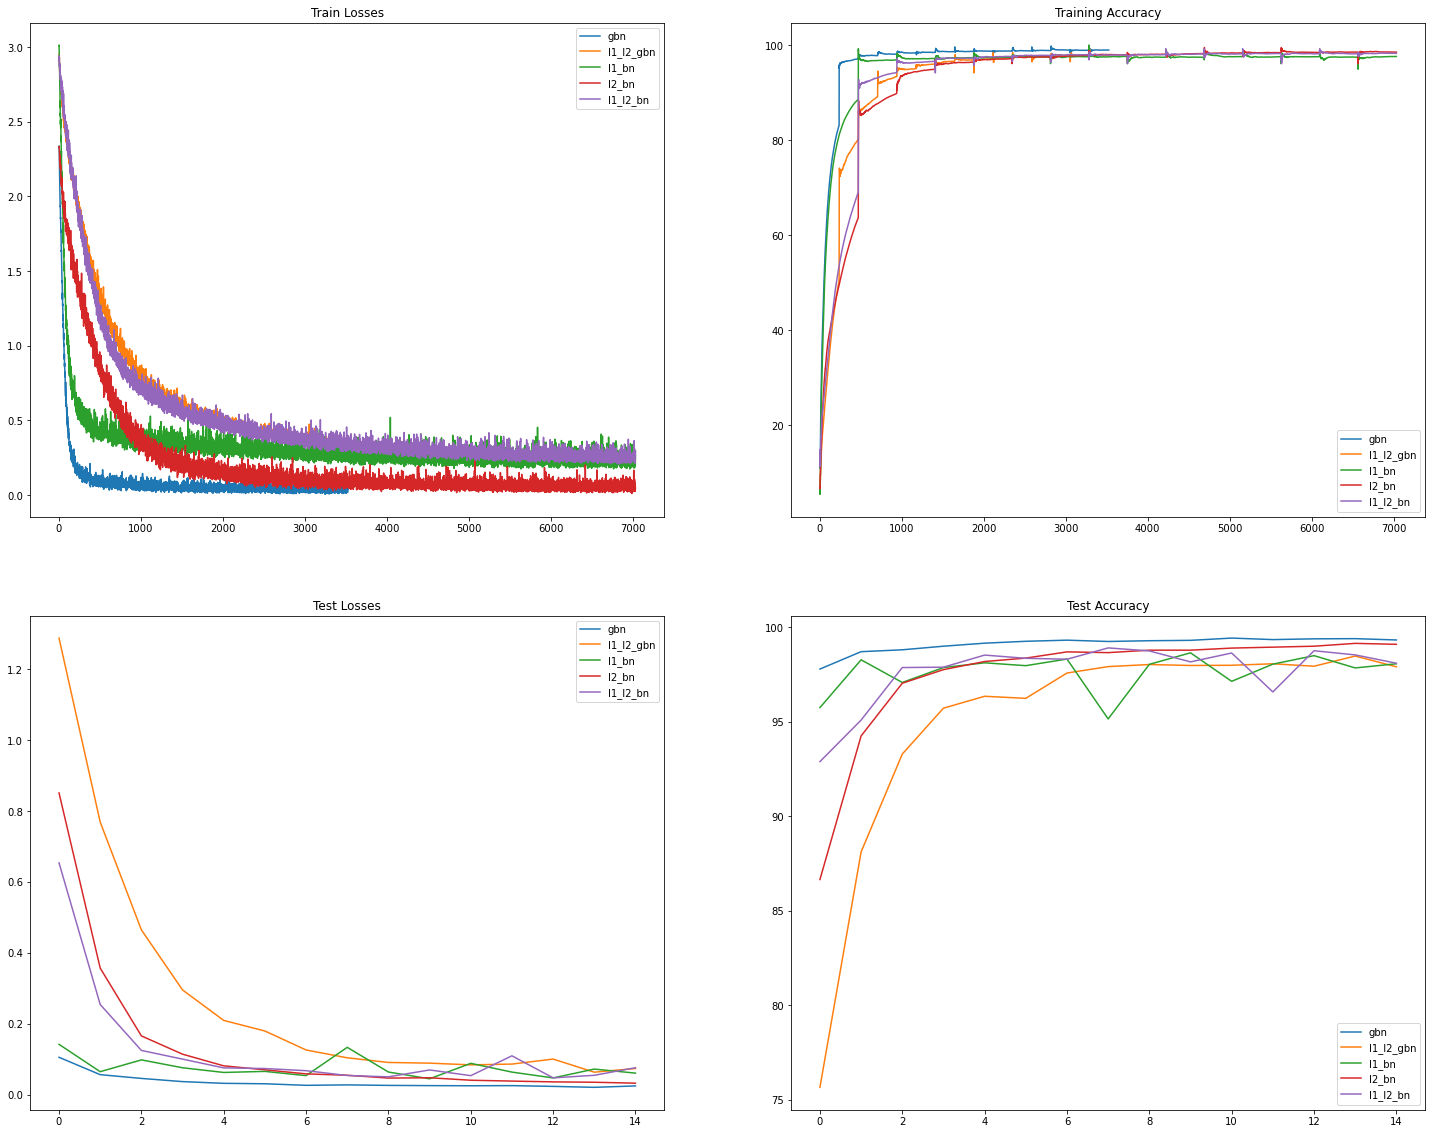

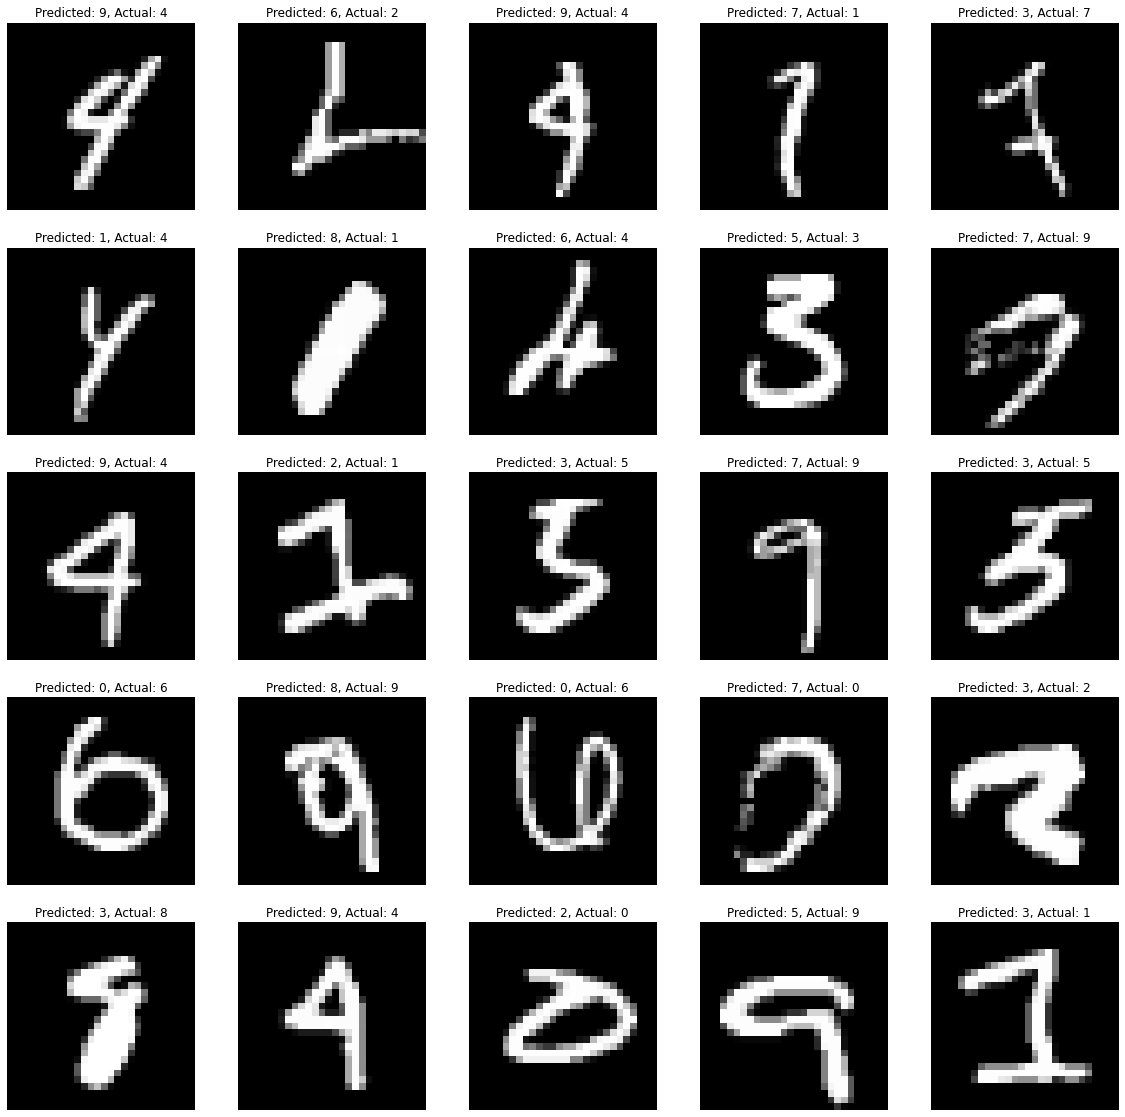

In [8]:
import gc
EPOCHS = 15

# list_modes = ['gbn', 'l1_l2_gbn', 'l1_bn', 'l2_bn', 'l1_l2_bn']
list_modes = ['gbn', 'l1_l2_gbn', 'l1_bn', 'l2_bn', 'l1_l2_bn']
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')


for mode in list_modes:
    gc.collect()
    print(f'Mode is {mode}')

    if mode in ['gbn', 'l1_l2_gbn']: # Larger batch sizes and GhostNet model for GBN
        model = GhostNet().to(device)
        dataloader_args = dict(shuffle=True, num_workers=4, pin_memory=True, batch_size=256) if torch.cuda.is_available() else dict(shuffle=True, batch_size=64) 
    
    else:
        model = Net().to(device) # Normal batch-sizes for rest
        dataloader_args = dict(shuffle=True, num_workers=4, pin_memory=True, batch_size=128) if torch.cuda.is_available() else dict(shuffle=True, batch_size=64)

    test_acc = []
    test_losses = []
    train_acc = []
    train_losses = []
    misclassified = None

    train_dataloader = DataLoader(train,**dataloader_args)
    test_dataloader = DataLoader(test, **dataloader_args)
    for epoch in range(EPOCHS):
        print('EPOCH - ', epoch)
        get_optim(mode)
        misclassified = model_testing(model, device, test_dataloader, test_acc, test_losses)
    
    # Plotting the misclassified images for GBN Model
    if mode is 'gbn':
        plot_misclassified(misclassified)

    axs[0,0].plot(train_losses)
    axs[0,1].plot(train_acc)
    axs[1,0].plot(test_losses)
    axs[1,1].plot(test_acc)

axs[0,0].legend(list_modes)
axs[0,1].legend(list_modes)
axs[1,0].legend(list_modes)
axs[1,1].legend(list_modes)
fig.savefig(os.path.join(img_dir, 'metrics.png'))
